# **Modeling and Evaluation Cluster Notebook**

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster


## Inputs

* outputs/datasets/collection/airplane_performance_study.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

Make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Imports

In [4]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib

from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Feat Scaling
from sklearn.decomposition import PCA  # PCA
from sklearn.cluster import KMeans  # ML algorithm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel  # Feat Selection
from sklearn.ensemble import GradientBoostingClassifier  # ML algorithm
from sklearn.metrics import classification_report

# Load Data

We are dropping:
* Model, Company because these are only meta data/identifiers
* 'Multi_Engine' and 'Engine_Type' becasue we want to evaluate against these
* THR and SHP both because they are difficult to interpret
* Hmax_(One) and ROC_(One) becasue since they ONLY apply to the Airplanes with a "True" under the "Multi Engine"-feature it would therefore skew the result. A run that included Hmax_(One) and ROC_(One) indeed show Hmax_(One) on top as the most important feature however ROC_(One) was even listed.

In [5]:
df = (pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv")
      .drop(['Model', 'Company', 'Multi_Engine', 'Engine_Type', 'THR', 'SHP', 'Hmax_(One)', 'ROC_(One)'], axis=1)
      )
print(df.shape)
df.head(3)


(857, 17)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317


---

# Cluster Pipeline with all data

##  ML Cluster Pipeline

In [6]:
print(df.dtypes)

Wing_Span    float64
Length       float64
Height       float64
TP_mods         bool
AUW          float64
MEW          float64
FW           float64
Vmax         float64
Vcruise      float64
Vstall       float64
Range        float64
Hmax         float64
ROC          float64
Vlo          float64
Slo          float64
Vl           float64
Sl           float64
dtype: object


In [7]:
# Convert boolean columns to strings
df['TP_mods'] = df['TP_mods'].replace({True: 'Yes', False: 'No'})

# Check the updated data types
print(df.dtypes)


Wing_Span    float64
Length       float64
Height       float64
TP_mods       object
AUW          float64
MEW          float64
FW           float64
Vmax         float64
Vcruise      float64
Vstall       float64
Range        float64
Hmax         float64
ROC          float64
Vlo          float64
Slo          float64
Vl           float64
Sl           float64
dtype: object


We will use K-means since this model is ideal for numerical continuous data and the majority of our data is numerical continuous. However it is mixed (both categorical and numeric continuous) which could warrant another method like K-modes or K-prototypes that are better suited for mixed data set.

The Threshold is set to 0.5 which is a very low (values are typically 0.85 - 0.9) which is first of all since our values are relatively normally distributed and we shall see that even this low threshold retains only two features! We have experimented with many different threshold values without seeing any significantly difference on n_components.

In [8]:
def PipelineCluster():
    """
    Constructs a machine learning pipeline for clustering.

    The pipeline includes steps for feature encoding, correlation-based feature selection,
    feature scaling, dimensionality reduction, and KMeans clustering.

    Steps:
    1. Encodes categorical variables using OrdinalEncoder.
    2. Selects features with SmartCorrelatedSelection to reduce multicollinearity.
    3. Scales features with StandardScaler.
    4. Applies PCA for dimensionality reduction to 50 components.
    5. Performs KMeans clustering to identify 50 clusters.

    Returns:
        Pipeline: A scikit-learn Pipeline object for clustering tasks.

    Categorical Variables:
        - TP_mods
        - Engine_Type

    KMeans Parameters:
        - n_clusters: 50
        - random_state: 0
    """
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=50, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


## Principal Component Analysis (PCA)

In [9]:
df.head(10)

,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317
3,35.000000,21.416667,8.583333,No,1300.0,800.0,127.3,88.0,78.0,37.0,210.0,13000.0,620.0,500.0,407.797297,850.0,642.046166
4,35.000000,21.416667,8.750000,No,1220.0,740.0,93.8,83.0,74.0,33.0,175.0,12500.0,370.0,632.0,297.056192,885.0,329.571813
5,36.083333,20.333333,8.750000,No,1250.0,786.0,100.5,78.0,72.0,33.0,180.0,11000.0,360.0,583.0,393.226454,880.0,542.445142
6,36.666667,34.833333,12.083333,No,6315.0,4275.0,1105.5,264.0,230.0,80.0,868.0,25000.0,1820.0,3080.0,1950.000000,2100.0,1425.000000
7,36.583333,34.750000,12.083333,No,6000.0,4125.0,1105.5,262.0,247.0,77.0,1020.0,28000.0,1755.0,2250.0,1800.000000,2076.0,1217.000000
8,36.666667,34.833333,12.083333,No,6000.0,4056.0,1105.5,257.0,235.0,77.0,1101.0,25000.0,1460.0,2490.0,1900.000000,2030.0,1230.000000
9,36.666667,34.833333,12.083333,No,6000.0,3958.0,1105.5,257.0,237.0,77.0,1174.0,30000.0,1460.0,2490.0,1900.000000,2030.0,1230.000000


We only recieve 2 components. Since the components is 0% and 100% the elbow method (select a number of components around a variance of 80%.) is rendered useless. Other dimensionality reduction techniques like t-SNE or UMAP could be considered.

The "SmartCorrelatedSelection" reduces the number of rows (dimensionality reduction) depending on what threshold value we set! https://feature-engine.trainindata.com/en/latest/user_guide/selection/SmartCorrelatedSelection.html

We are not concerned with the warnings below.

In [10]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(857, 2) 
 <class 'numpy.ndarray'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Apply PCA separately to the scaled data

In [11]:
print(df_pca[:10])

[[-0.27190961 -0.5019635 ]
 [-0.27190961 -0.54756968]
 [-0.27190961 -0.55082727]
 [-0.27190961 -0.55082727]
 [-0.27190961 -0.5560394 ]
 [-0.27190961 -0.55408485]
 [-0.27190961 -0.22409155]
 [-0.27190961 -0.24461433]
 [-0.27190961 -0.24461433]
 [-0.27190961 -0.24461433]]


* The 2 components explain 100.0% of the data 



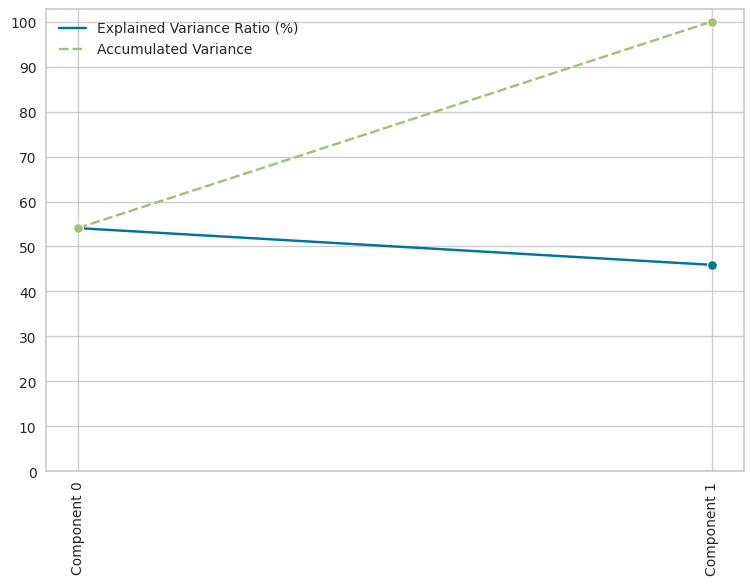

In [12]:
sns.set_style("whitegrid")

n_components = 2 # Adapted this to two since this value cannot be higher than 
# the number of retained columns in the df_pca which was only three with a 
# threshold value as low as 0,6


def pca_components_analysis(df_pca, n_components):
    """
    Analyzes and visualizes the explained variance of PCA components.

    This function fits PCA to the provided DataFrame, calculates the explained variance ratio 
    for each principal component, and plots both the explained and accumulated variance.

    Parameters:
        df_pca (DataFrame): A pandas DataFrame containing standardized data for PCA.
        n_components (int): The number of principal components to retain (must be ≤ number of features).

    Outputs:
        Prints the total percentage of variance explained by the specified components and displays a line plot.

    Notes:
        Ensure `df_pca` is preprocessed for PCA suitability.
    """
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 2 components explain 100.0% of the data 



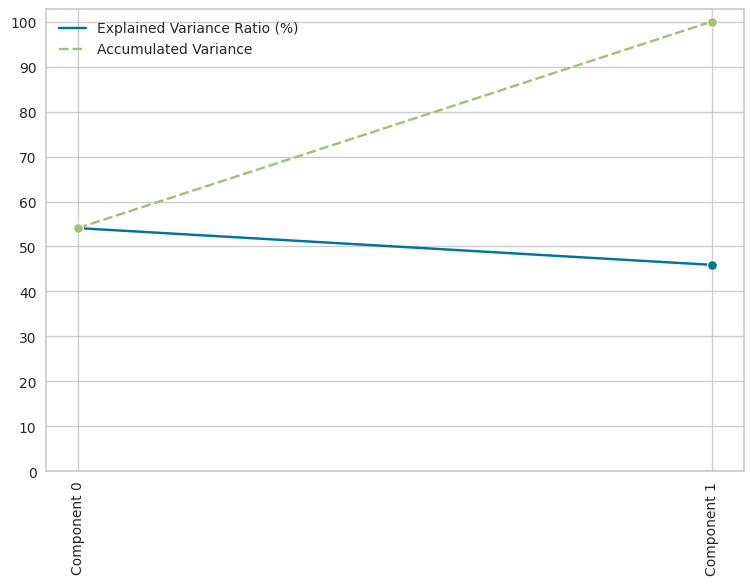

In [13]:
pca_components_analysis(df_pca=df_pca,n_components=2)

The Plot with Accumulated CVariance Ratio incldue only 2 components (n_components=2) and we select to retain both thesse since our main purpos with this 
analysis is interpretability and we want to retain as much information as possible for this.

In [14]:
def PipelineCluster():
    """
    Creates a clustering pipeline with feature encoding, selection, scaling, PCA, and KMeans.

    This function constructs a scikit-learn Pipeline that:
    1. Encodes categorical variables using OrdinalEncoder.
    2. Applies Smart Correlated Selection to filter features based on correlation.
    3. Scales features with StandardScaler.
    4. Performs PCA to reduce dimensionality to 2 components.
    5. Clusters the data into 50 groups using KMeans.

    Returns:
        Pipeline: A scikit-learn Pipeline object ready for fitting and transforming data.
    """
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        # we update n_components to 2
        ("PCA", PCA(n_components=2, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=2, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

## Elbow Method and Silhouette Score

In [15]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(857, 2) 
 <class 'numpy.ndarray'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


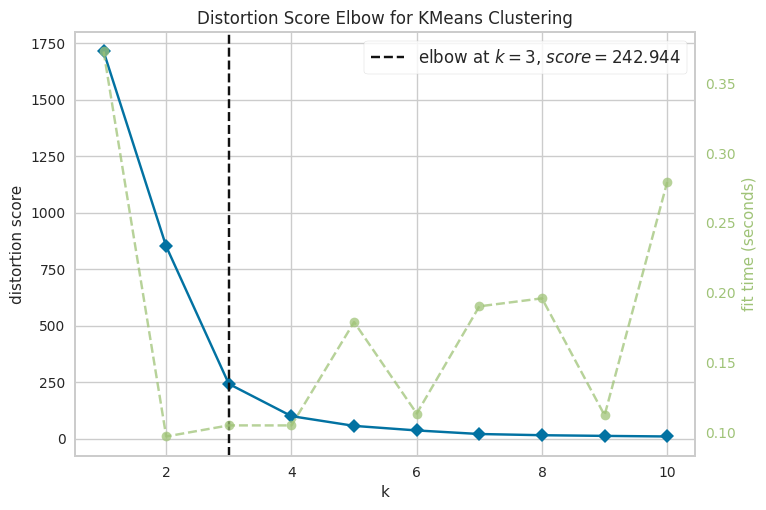

In [16]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


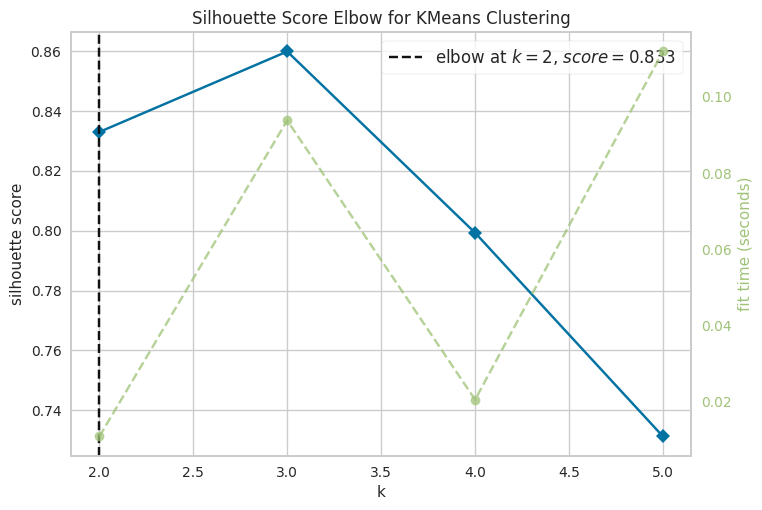



=== Silhouette plot for 2 Clusters ===


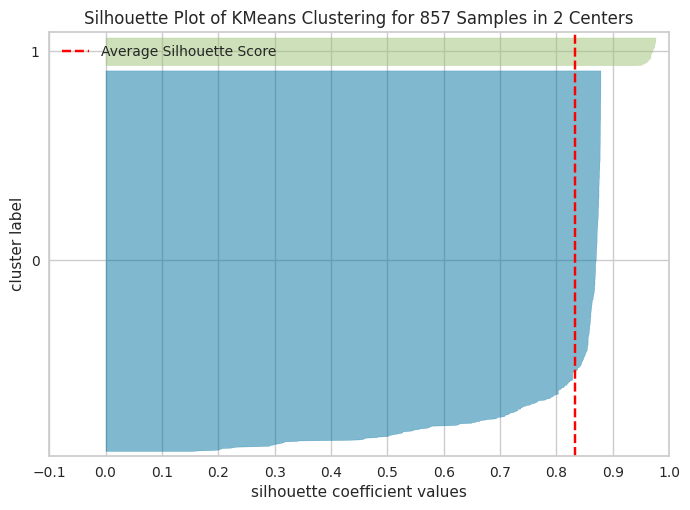



=== Silhouette plot for 3 Clusters ===


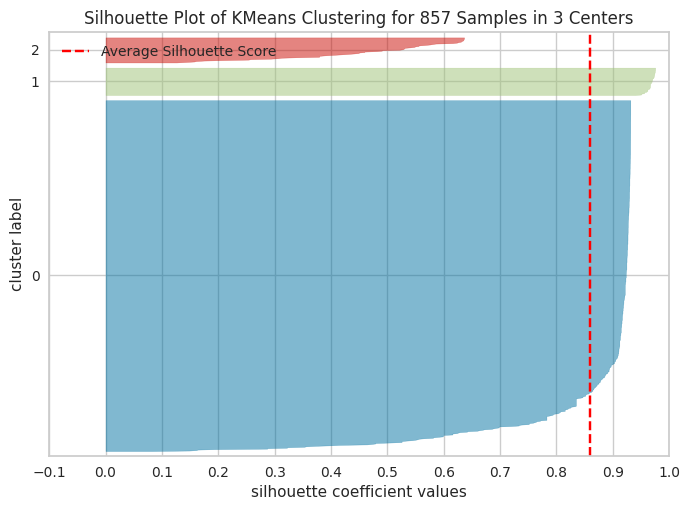



=== Silhouette plot for 4 Clusters ===


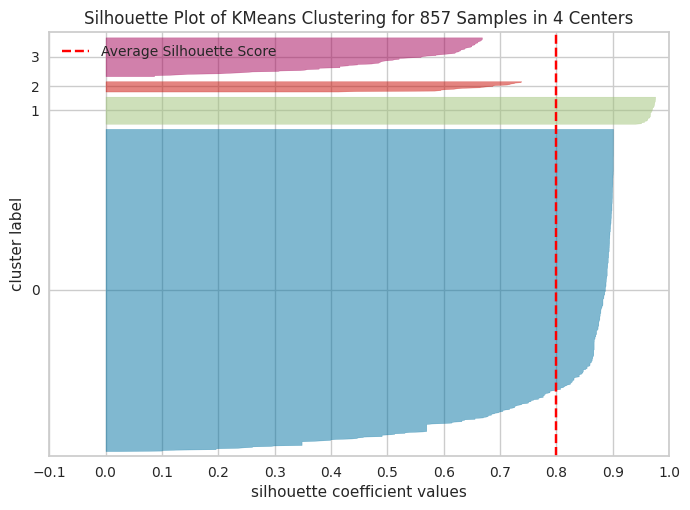



=== Silhouette plot for 5 Clusters ===


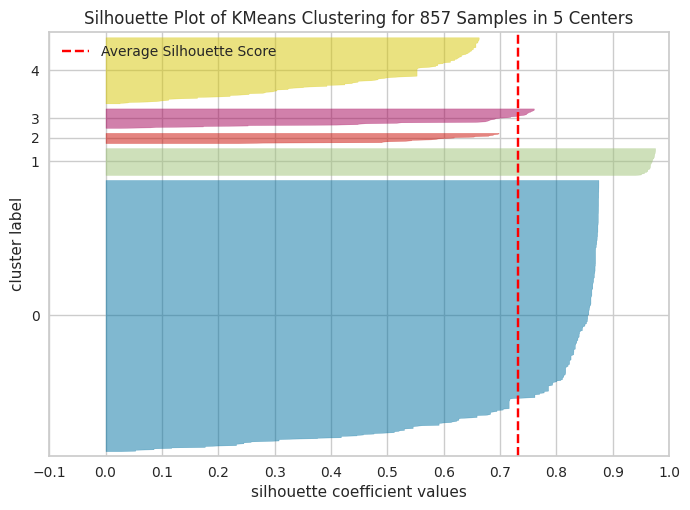

In [17]:
# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


The Elbow Method gives a cluster size of two or three. The Silhouette shadow plots appear to clearly point towards 2 clusters so this will be our choice. With two clusters both reaches past the mean line.

In [18]:
def PipelineCluster():
    """
    Constructs a clustering pipeline for feature processing and KMeans clustering.

    This function creates a scikit-learn Pipeline that:
    1. Encodes categorical variables with OrdinalEncoder.
    2. Filters features using Smart Correlated Selection based on correlation.
    3. Scales features with StandardScaler.
    4. Reduces dimensionality to 2 components using PCA.
    5. Clusters data into 2 groups using KMeans.

    Returns:
        Pipeline: A scikit-learn Pipeline object configured for clustering.
    """
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=2, random_state=0)),

        # we update n_clusters to 2
        ("model", KMeans(n_clusters=2, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=2, random_state=0)),
                ('model', KMeans(n_clusters=2, random_state=0))])

## Fit Cluster Pipeline

Quick recap of our data for training cluster pipeline

In [19]:
X = df.copy()
print(X.shape)
X.head(3)

(857, 17)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317


Fit Cluster pipeline

In [20]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['Wing_Span', 'Length',
                                                     'Height', 'TP_mods', 'AUW',
                                                     'MEW', 'FW', 'Vmax',
                                                     'Vcruise', 'Vstall',
                                                     'Range', 'Hmax', 'ROC',
                                                     'Vlo', 'Slo', 'Vl',
                                                     'Sl'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_component

## Add cluster predictions to dataset

We add a column "Clusters" (with the cluster pipeline predictions) to the dataset

In [21]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(857, 18)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl,Clusters
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075,0
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824,0
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317,0


* Clusters frequencies 
   Clusters
0      0.93
1      0.07 




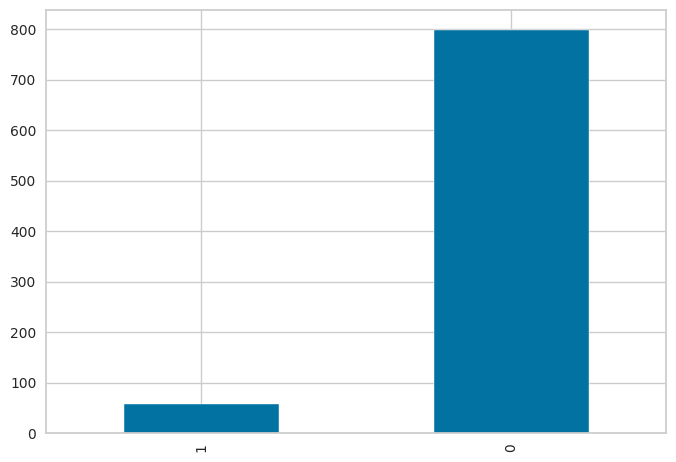

In [22]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

In [23]:
print(df_analysis.shape)


(857, 2)


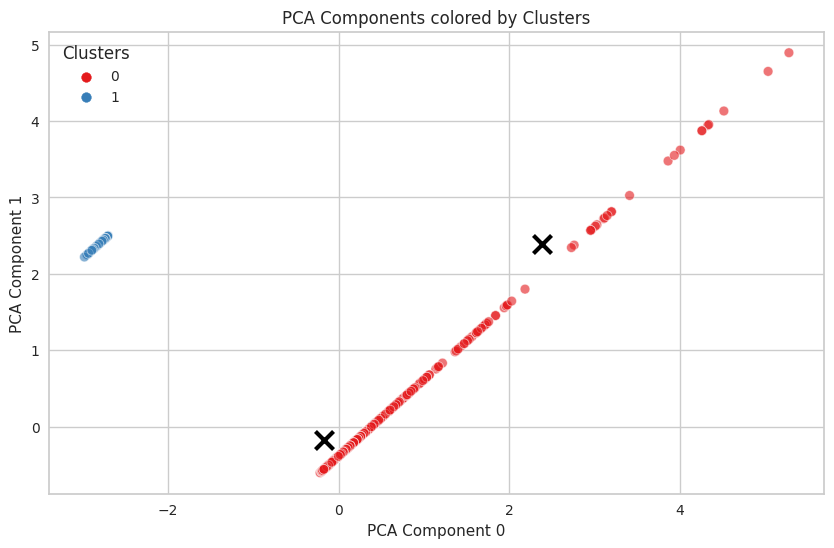

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],  # Original code is: y=df_analysis[:, 1] but that gives an error since it tries to acces the second column of a one column df
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 1], y=pipeline_cluster['model'].cluster_centers_[:, 1],  # Same here! Original code: cluster_centers_[:, 0]
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()


The fact that the centroid for the smaller cluster (blue) is far away (lateraly) from the actual datapoint (but close longitudinally) might suggest low intrinsic dimensionality that the n_components should have been choosen to 1 instead of 2. Other reasons could be: Poor Cluster Quality, Outliers, High Variability or Feature Scaling Issues.

The alignment of clusters along lines indicates that there are strong linear relationships in the data and therefore perhaps the cluster patterns could be captured with fewer components. The linear relationships probably has the background that the performance features follow similar patterns (what is good for one feature is also good for another feature).The fact that the clusters are clearly spaced from each other, like the smallest (green) cluster suggest that this is a categorical feature that "lifts" all the other features an equal part. Such a candidate would me the TP mods that we have seen stick out before. This is also one of only two categorical values since we have dropped Multi Engine.

In [25]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0      0
1      0
2      0
3      0
4      0
      ..
852    0
853    0
854    0
855    0
856    0
Name: Clusters, Length: 857, dtype: int32

## Fit a classifier, where the target is cluster predictions and features remaining variables

We copy `X` to a DataFrame `df_clf`

In [26]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(857, 18)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl,Clusters
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075,0
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824,0
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317,0


Split Train and Test sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(685, 17) (172, 17)


Create classifier pipeline steps

In [28]:
def PipelineClf2ExplainClusters():
    """
    Creates a classification pipeline with feature selection and scaling.

    This function constructs a scikit-learn Pipeline that performs the following steps:
    1. Encodes categorical variables using OrdinalEncoder.
    2. Selects features based on correlation with the target variable using Smart Correlation Selection.
    3. Scales features with StandardScaler.
    4. Applies SelectFromModel with a Gradient Boosting Classifier to select important features.
    5. Trains a Gradient Boosting Classifier on the selected features.

    Returns:
        Pipeline: A scikit-learn Pipeline object for classification tasks.
    """
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

Fit the classifier to the training data

In [29]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['Wing_Span', 'Length',
                                                     'Height', 'TP_mods', 'AUW',
                                                     'MEW', 'FW', 'Vmax',
                                                     'Vcruise', 'Vstall',
                                                     'Range', 'Hmax', 'ROC',
                                                     'Vlo', 'Slo', 'Vl',
                                                     'Sl'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
    

## Evaluate classifier performance on Train and Test Sets

In [30]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00        48

    accuracy                           1.00       685
   macro avg       1.00      1.00      1.00       685
weighted avg       1.00      1.00      1.00       685



In [31]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       1.00      1.00      1.00        11

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172



## Assess the most important Features that define a cluster

The most important feature being TP mods is rather disappointing since this is a trivial result from an Aircraft Design point of view.

* These are the 1 most important features in descending order. The model was trained on them: 
['TP_mods'] 



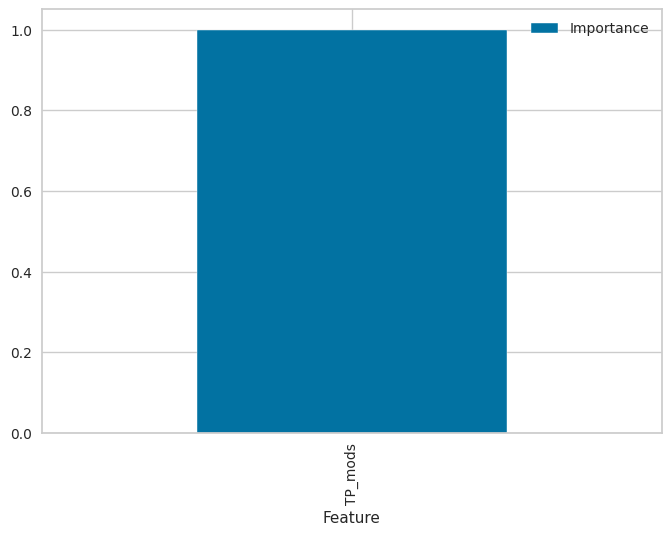

In [32]:
# after data cleaning and feature engineering, the feature space changes

# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


We will store the best_features to use at a later stage.

In [33]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['TP_mods']

## Cluster Analysis

Load function that plots a table with description for all Clusters

In [34]:
def DescriptionAllClusters(df, decimal_points=3):
    """
    Generate descriptive statistics for each cluster in the provided DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing cluster data, including a 'Clusters' column.
    decimal_points (int): Number of decimal points to format numeric summaries.

    Returns:
    pd.DataFrame: A DataFrame with descriptive statistics for each cluster.
    """
    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    """
    Generate descriptive statistics for a specific cluster's features.

    Parameters:
    EDA_Cluster (pd.DataFrame): DataFrame containing features of a specific cluster.
    cluster (any): Identifier for the cluster being analyzed.
    decimal_points (int): Number of decimal points for rounding numeric statistics.

    Returns:
    pd.DataFrame: A DataFrame summarizing the statistics of the cluster's features.
    """
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription


Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

In [35]:
def cluster_distribution_per_variable(df, target):
    """

    Visualizes the distribution of clusters across a specified variable.

    This function generates two plots using Plotly:
    1. A bar plot showing the count of each target level within each cluster.
    2. A line plot depicting the relative percentage of each target level in each cluster.

    Parameters:
        df (DataFrame): A pandas DataFrame containing cluster predictions and the target variable.
        target (str): The name of the variable to analyze against the clusters.

    Returns:
        None: Displays plots directly in the Jupyter notebook.

    Notes:
        The DataFrame must include a 'Clusters' column for cluster assignments.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')


Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.


In [36]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(857, 2)


,TP_mods,Clusters
0,No,0
1,No,0
2,No,0


We want also to analyse distribution of Multi Engine and Engine Types.

In [37]:
df_multi_engine = pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv").filter(['Multi_Engine'])
df_multi_engine['Multi_Engine'] = df_multi_engine['Multi_Engine'].astype('object')
df_multi_engine.head(3)

,Multi_Engine
0,False
1,False
2,False


Also testing for Engine Type albeit not the aim for the exercise.

In [38]:
df_engine_type = pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv").filter(['Engine_Type'])
df_engine_type['Engine_Type'] = df_engine_type['Engine_Type'].astype('object')
df_engine_type.head(3)

,Engine_Type
0,0
1,0
2,0


### Cluster profile based on the best features

For Multi Engine.

In [39]:
pd.set_option('display.max_colwidth', None)
clusters_profile_multi_engine = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_multi_engine], axis=1), decimal_points=0)
clusters_profile_multi_engine.to_csv(f"outputs/ml_pipeline/cluster_analysis/v1/clusters_profile_multi_engine.csv")
clusters_profile_multi_engine

/tmp/ipykernel_11369/1644880643.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_11369/1644880643.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


,TP_mods,Multi_Engine
Cluster,,
0,'No': 100%,"'False': 54% , 'True': 46%"
1,'Yes': 100%,"'True': 68% , 'False': 32%"


...and for Engine Type

In [40]:
pd.set_option('display.max_colwidth', None)
clusters_profile_engine_type = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_engine_type], axis=1), decimal_points=0)
clusters_profile_engine_type.to_csv(f"outputs/ml_pipeline/cluster_analysis/v1/clusters_profile_engine_type.csv")
clusters_profile_engine_type

/tmp/ipykernel_11369/1644880643.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_11369/1644880643.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


,TP_mods,Engine_Type
Cluster,,
0,'No': 100%,"'0': 69% , '2': 19% , '1': 12%"
1,'Yes': 100%,"'0': 97% , '1': 3%"


The above Cluster Profile is very important since we from this plot can draw conclusions of the patterns.

The description of the clusters tells us not surprisingly that the modification to the Engine Performance (TP_mods) was perfectly clustered and that Airplanes without TP mods are pretty much fifty-fifty when it comes to Multi Engine. Furthermore it shows that the TP mods all most only appear on Piston Engines.

The most important conclusion from this clustering exercise is that TP mods appear to be:
* Exclusively made on piston powered airplanes!
* more common on Multi Engine Airplanes where 2/3 of the TP mods being done on Multi Engines.

Since only one feature has been retained together with that the value of this clustering exercise has proved to be disappointing makes us not continue any furter with a re-fitting of the pipeline.

The reason that this clustering did not yield much valuable insight is most likely becaus the the data set was to homogenous in terms of airplane types and that the airplanes in the data set was quite evenly and continuously distributed in terms of features such as size for example. If we would instead would have dropped the mid sized airplanes or introduced another type of airplanes such as fighter jets or drones we would most likely have experienced a more clear clustering. 

### Clusters distribution across Multi Engine and Engine Type distributions & Relative Percentage of Multi Engine and Engine Type in each cluster

In [41]:
df_cluster_vs_multi_engine=  df_multi_engine.copy()
df_cluster_vs_multi_engine['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_multi_engine, target='Multi_Engine')
plt.savefig(f"outputs/ml_pipeline/cluster_analysis/v1/cluster_vs_multi_engine.png", bbox_inches='tight', dpi=150) # Save plot

Clusters distribution across Multi_Engine levels


Relative Percentage (%) of Multi_Engine in each cluster


<Figure size 800x550 with 0 Axes>

In [42]:
df_cluster_vs_engine_type=  df_engine_type.copy()
df_cluster_vs_engine_type['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_engine_type, target='Engine_Type')
plt.savefig(f"outputs/ml_pipeline/cluster_analysis/v1/cluster_vs_engine_type.png", bbox_inches='tight', dpi=150) # Save plot

Clusters distribution across Engine_Type levels


Relative Percentage (%) of Engine_Type in each cluster


<Figure size 800x550 with 0 Axes>

---

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [43]:
version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


[Errno 17] File exists: 'outputs/ml_pipeline/cluster_analysis/v1'


## Cluster pipeline

In [44]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['Wing_Span', 'Length',
                                                     'Height', 'TP_mods', 'AUW',
                                                     'MEW', 'FW', 'Vmax',
                                                     'Vcruise', 'Vstall',
                                                     'Range', 'Hmax', 'ROC',
                                                     'Vlo', 'Slo', 'Vl',
                                                     'Sl'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_component

In [45]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

['outputs/ml_pipeline/cluster_analysis/v1/cluster_pipeline.pkl']

## Train Set

In [46]:
df_cluster_study=df
print(df.shape)
df_cluster_study.head(3)

(857, 17)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317


In [47]:
df_cluster_study.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

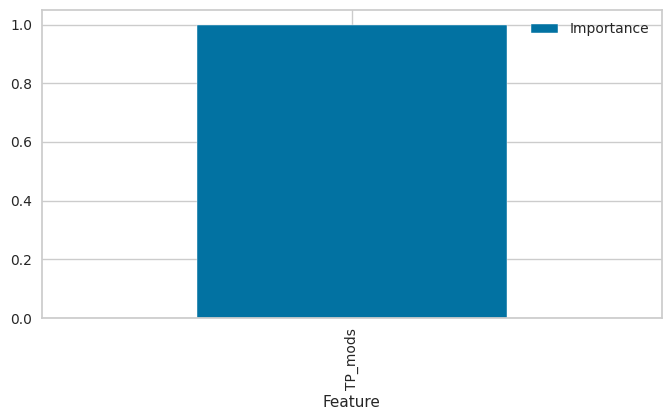

In [48]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

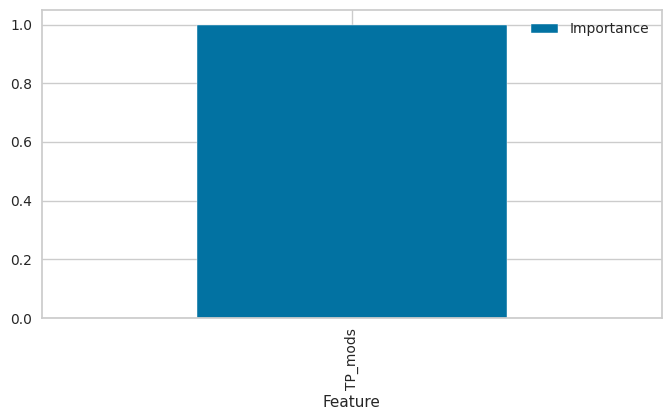

In [49]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster silhouette plot

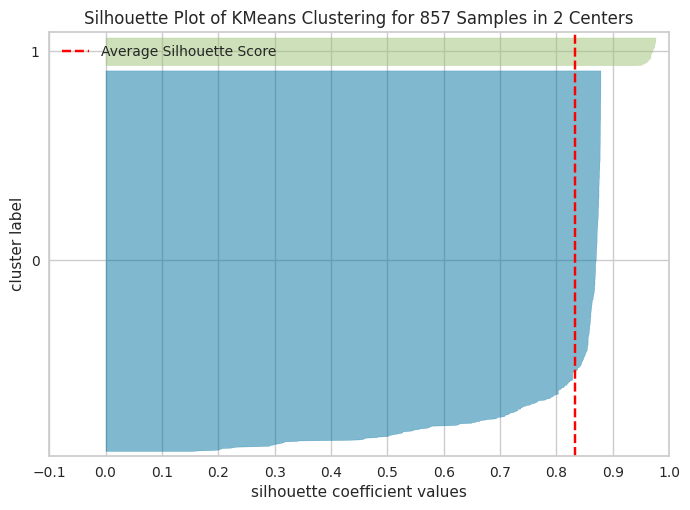

In [50]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

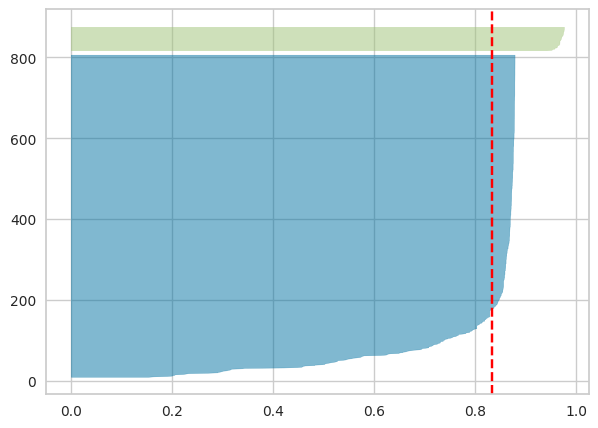

In [51]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Based on the profile results we can label the two clusters in the following fashion:
* **Cluster 0** represent airplanes that does not have TP mods and is made up by all Engine Types (piston, propjet and jet).
* **Cluster 1** represent airplanes that has TP mods and is almost exclusively made up by Piston powered Airplanes
(Airplane Type: piston) indicating that the TP mods is a feature applicable only on Piston Powered Engines. Furthermore Multi Engine Airplanes represented 2/3 of all TP mods.